# Определение перспективного тарифа для компании "Мегалайн"

**Цель проекта:** Проверить две гипотезы, связанные с объёмом выручки в зависимости от выбранного тарифного плана и города проживания пользователя.

**Задачи проекта:**
- Расчитать параметры активности пользователей в зависимости от месяца
- Проанализировать действия пользователей, дать характеристику их активности
- Проверить гипотезы, сформулировать выводы

**Содержание:**
* [1. Предобработка данных](#1)
* [2. Расчёт основных показателей для каждого пользователя](#2)
* [3. Анализ данных](#3)
* [4. Проверка гипотез](#4)
* [4.1 Гипотеза №1](#4.1)
* [4.2 Гипотеза №2](#4.2)
* [5. Общие выводы](#5)

<a id="1"></a>
## Предобработка данных

Импортируем все небходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go

Сохраним датасеты в переменные

In [2]:
data_calls = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/6. Определение перспективного тарифа для компании Мегалайн/data_calls.csv')
data_internet = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/6. Определение перспективного тарифа для компании Мегалайн/data_internet.csv')
data_messages = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/6. Определение перспективного тарифа для компании Мегалайн/data_messages.csv')
data_tariffs = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/6. Определение перспективного тарифа для компании Мегалайн/data_tariffs.csv')
data_users = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/6. Определение перспективного тарифа для компании Мегалайн/data_users.csv')

Ознакомимся с данными о звонках

In [3]:
display (data_calls.dtypes)
display (data_calls.sample (5))

id            object
call_date     object
duration     float64
user_id        int64
dtype: object

,id,call_date,duration,user_id
42707,1105_114,2018-12-17,0.00,1105
67795,1172_0,2018-11-29,13.85,1172
198243,1486_76,2018-12-22,4.64,1486
43618,1109_593,2018-06-06,13.89,1109
81475,1203_48,2018-03-15,11.12,1203


Меняем тип данных в колонке call_date и проверяем колонку duration на корректность значений

In [4]:
data_calls ['call_date'] = pd.to_datetime (data_calls ['call_date'])
data_calls ['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Проверяем датасет на наличие пропусков и дубликатов

In [5]:
display (data_calls.duplicated().sum())
data_calls.isna().sum()

0

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Датасет содержит 202607 записей. Продолжительность звонков находится в диапазоне от 0 до 38 минут. Время совершения вызова было преобразовано в формат `date_time` для дальнейшей работы с датой. Колонка `id` содержит в себе id пользователя и, вероятнее всего, порядковый номер звонка у данного пользователя по счёту, приводить её к другому типу данных не будем. Дубликаты и пропуски в датасете отсутствуют.

Ознакомимся с данными об использовании интернета

In [6]:
display (data_internet.dtypes)
display (data_internet.sample (5))

Unnamed: 0        int64
id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

,Unnamed: 0,id,mb_used,session_date,user_id
120086,120086,1404_181,472.69,2018-11-24,1404
50218,50218,1172_500,35.00,2018-08-30,1172
90993,90993,1308_176,193.51,2018-05-30,1308
4111,4111,1012_384,617.57,2018-04-16,1012
35055,35055,1123_19,119.47,2018-04-03,1123


Меняем тип данных в колонке session_date, удаляем колонку Unnamed: 0 и проверяем клонку mb_used на корректность данных

In [7]:
data_internet ['session_date'] = pd.to_datetime (data_internet ['session_date'])
data_internet = data_internet.drop (columns = 'Unnamed: 0')
data_internet ['mb_used'].describe ()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Проверяем датасет на наличие пропусков и дубликатов

In [8]:
display (data_internet.duplicated().sum())
data_internet.isna().sum()

0

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Датасет содержит 149396 записей. Дата сессии была преобразована в формат date_time. Колонка `Unnamed: 0` дублирует номер записи - от неё можно избавиться. Дубликаты и пропуски в датасете отсутствуют. Количество потраченных мегабайт за одну сессию находится в диапазоне от 0 до 1724 мб. В случае со звонками, значение 0 означает пропущенный вызов. В случае с использованием интернета это может быть ошибка в данных. Необходимо узнать количество таких сессий, где трафик не использовался.

In [9]:
print (len (data_internet [data_internet ['mb_used'] == 0]))

19598


Почти 20 тысяч сессий с "нулевым" использованием трафика - это значительная доля датасета, которая сильно повиляет на дальнейшее исследование. Возможно, подобные записи говорят о попытке пользователя получить доступ в интернет при уже использованном лимите трафика (был зафиксирован сам факт использования услуги, но трафик задействован не был).

Ознакомимся с данными о сообщениях

In [10]:
display (data_messages.dtypes)
display (data_messages.sample (5))

id              object
message_date    object
user_id          int64
dtype: object

,id,message_date,user_id
55020,1244_186,2018-07-19,1244
77634,1327_131,2018-10-02,1327
105878,1427_52,2018-04-26,1427
95539,1393_113,2018-12-14,1393
19123,1083_312,2018-09-04,1083


Меняем тип данных в колонке message_date и проверяем объём датасета

In [11]:
data_messages ['message_date'] = pd.to_datetime (data_messages ['message_date'])
print ('Количество записей в датасете:', len (data_messages))

Количество записей в датасете: 123036


Проверяем датасет на наличие пропусков и дубликатов

In [12]:
display (data_messages.duplicated().sum())
data_messages.isna().sum()

0

id              0
message_date    0
user_id         0
dtype: int64

Датасет содержит 123036 записей. Время отправки сообщения было преобразовано в формат date_time для дальнейшей работы с датой. Числовых значений в данном датасете нет. Дубликаты и пропуски в датасете отсутствуют. 

Ознакомимся с данными о тарифах

In [13]:
display (data_tariffs.dtypes)
display (data_tariffs.head ())

messages_included         int64
mb_per_month_included     int64
minutes_included          int64
rub_monthly_fee           int64
rub_per_gb                int64
rub_per_message           int64
rub_per_minute            int64
tariff_name              object
dtype: object

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Датасет содержит всего две строки с информацией о двух разных тарифах. Типы данных записаны корректно. Для удобства дальнйшей работы транспонируем таблицу, удалив строку с названиями тарифов. Помимо этого мегабайты переведём в гигабайты.

In [14]:
data_tariffs = data_tariffs.T.rename ({0: 'smart', 1: 'ultra'}, axis = 1)
data_tariffs.drop (data_tariffs.tail (1).index, inplace = True)

for i in ['smart', 'ultra']:
    data_tariffs [i][1] = data_tariffs [i][1] / 1024
    
data_tariffs

,smart,ultra
messages_included,50,1000
mb_per_month_included,15.0,30.0
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1


Ознакомимся с данными о пользователях

In [15]:
display (data_users.dtypes)
display (data_users.sample (5))

user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
494,1494,62,NaN,Омск,Ренат,Андропов,2018-08-17,smart
470,1470,23,NaN,Новокузнецк,Эллада,Лосева,2018-10-19,smart
26,1026,32,NaN,Мурманск,Евгений,Бородин,2018-10-06,smart
184,1184,21,NaN,Барнаул,Снежана,Тарасова,2018-09-03,smart
102,1102,28,NaN,Москва,Марта,Королькова,2018-06-16,smart


In [16]:
data_users ['reg_date'] = pd.to_datetime (data_users ['reg_date'])
display (data_users ['age'].describe())
print ('Количество записей в датасете:', len (data_users))
print ('Уникальные названия тарифов:', data_users ['tariff'].unique())
display (data_users.isna().sum())
display (data_messages.duplicated().sum())

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Количество записей в датасете: 500
Уникальные названия тарифов: ['ultra' 'smart']


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

0

Датасет содержит 500 записей об уникальных пользователях, возрастом от 18 до 75 лет. У каждого из пользователей указан один из тарифов. 462 из 500 человека продолжали использовать тариф на момент выгрузки данных. Дубликатов в датасете нет. Пропущенные значения в колонке `churn_date` заменять не будем.

<a id="2"></a>
## Расчёт основных показателей для каждого пользователя
Добавим колонку month с номером месяца в каждый из датасетов

In [17]:
for i, j in zip ([data_calls, data_internet, data_messages], ['call_date', 'session_date', 'message_date']):
    i ['month'] = i [j].dt.month

Округлим значения длительности звонков до минут и значения израсходованных мегабайт до гигабайт.

In [18]:
data_calls ['duration'] = data_calls ['duration'].apply (np.ceil)
data_internet ['mb_used'] = (data_internet ['mb_used'] / 1024).apply (np.ceil)
data_internet = data_internet.rename ({'mb_used': 'gb_used'}, axis = 1)

Сгруппируем три таблицы с данными о звонках, сообщениях и интернет-трафике для получения необходимых рассчётов.

In [19]:
data_calls_grouped = data_calls.groupby (['user_id', 'month'], as_index = False) \
                               .agg ({'id': 'count', 'duration': 'sum'}) \
                               .rename ({'id': 'calls_count', 'duration': 'minutes_total'}, axis = 1)

data_messages_grouped = data_messages.groupby (['user_id', 'month'], as_index = False)['id'].count() \
                                     .rename ({'id': 'messages_count'}, axis = 1)

data_internet_grouped = data_internet.groupby (['user_id', 'month'], as_index = False)['gb_used'].sum() \
                                     .rename ({'gb_used': 'gb_total'}, axis = 1)

Соединим сгруппированные таблицы, а также название тарифов из `data_users` в переменную `data_main`.

In [20]:
data_main = data_users [['user_id']].merge (data_calls_grouped, on = 'user_id', how = 'outer')
data_main = data_main.merge (data_messages_grouped, on = ['user_id', 'month'], how = 'outer')
data_main = data_main.merge (data_internet_grouped, on = ['user_id', 'month'], how = 'outer')
data_main = data_main.merge (data_users [['user_id', 'tariff']], on = 'user_id', how = 'outer')
data_main = data_main.fillna (0)

Преобразуем тип данных в тех колонках, где это необходимо.

In [21]:
for i in ['month', 'calls_count', 'minutes_total', 'messages_count']:
    data_main [i] = data_main [i].astype ('int')

Напишем функцию для расчёта выручки с каждого клиента по месяцам.

In [22]:
def revenue (tariff):
    data_remains = (data_main ['messages_count'] - data_tariffs [tariff][0]).reset_index() \
                                                                            .rename ({'messages_count': 'messages_remains'}, axis = 1)
    data_remains ['minutes_remains'] = data_main ['minutes_total'] - data_tariffs [tariff][2]
    data_remains ['gb_remains'] = (data_main ['gb_total'] - data_tariffs [tariff][1]).apply (np.ceil)

    for i, j in zip (['messages_remains', 'minutes_remains', 'gb_remains'], [5, 6, 4]):
        data_remains [i] = np.where (data_remains [i] > 0, data_remains [i] * data_tariffs [tariff][j], 0)
    
    data_remains ['revenue'] = data_remains ['messages_remains'] + data_remains ['minutes_remains'] + data_remains ['gb_remains'] + data_tariffs [tariff][3]
    return data_remains ['revenue']

Применим функцию в новой колонке `data_main`.

In [23]:
data_main ['revenue'] = np.where (data_main ['tariff'] == 'smart', revenue ('smart'), revenue ('ultra'))
data_main.sample (10)

,user_id,month,calls_count,minutes_total,messages_count,gb_total,tariff,revenue
448,1070,12,35,280,12,34.0,smart,4350.0
326,1052,12,111,859,96,44.0,smart,7565.0
1746,1275,8,72,451,29,35.0,smart,4550.0
2532,1394,8,57,461,1,22.0,smart,1950.0
2834,1437,12,49,335,11,55.0,smart,8550.0
2398,1377,7,185,1311,13,9.0,ultra,1950.0
2561,1397,12,33,232,0,41.0,ultra,3600.0
1225,1189,5,80,568,23,47.0,smart,7154.0
1065,1168,8,154,1120,48,60.0,ultra,6450.0
2598,1403,11,15,109,49,71.0,ultra,8100.0


Проверим корректность данных после слияния нескольких датасетов.

In [24]:
data_main.duplicated().sum()

0

In [25]:
data_main.isna().sum()

user_id           0
month             0
calls_count       0
minutes_total     0
messages_count    0
gb_total          0
tariff            0
revenue           0
dtype: int64

In [26]:
data_main ['month'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  0])

В данных нет дубликатов и пропущенных значений, однако, есть записи с нулевым номером месяца.

In [27]:
data_main.query ('month == 0')

,user_id,month,calls_count,minutes_total,messages_count,gb_total,tariff,revenue
570,1091,0,0,0,0,0.0,ultra,1950.0
672,1106,0,0,0,0,0.0,ultra,1950.0
829,1128,0,0,0,0,0.0,ultra,1950.0
1477,1231,0,0,0,0,0.0,ultra,1950.0
2086,1328,0,0,0,0,0.0,ultra,1950.0
2339,1371,0,0,0,0,0.0,smart,550.0
3051,1473,0,0,0,0,0.0,ultra,1950.0
3156,1489,0,0,0,0,0.0,smart,550.0


В датасете есть 8 записей о клиентах, которые не пользовались услугами оператора ни в один из месяцев, однако, расчёт выручки по этим клиентам был посчитан, как за нулевой месяц. Рассмотрим информацию об активности этих восьми клиентов в другие месяца.

Сохраним отдельно id клиентов, имеющих нулевые месяца, проверим наличие активности по каждому из этих клиентов.

In [28]:
zero_users = data_main.query ('month == 0')['user_id'].unique()
data_main [data_main ['user_id'].isin (zero_users)].sort_values (by = ['user_id', 'month']).sample (10)

,user_id,month,calls_count,minutes_total,messages_count,gb_total,tariff,revenue
572,1091,6,0,0,30,20.0,ultra,1950.0
2087,1328,10,0,0,6,47.0,ultra,4500.0
3055,1473,11,0,0,14,40.0,ultra,3450.0
1477,1231,0,0,0,0,0.0,ultra,1950.0
1485,1231,12,0,0,191,67.0,ultra,7500.0
1480,1231,7,0,0,211,51.0,ultra,5100.0
1478,1231,5,0,0,55,20.0,ultra,1950.0
570,1091,0,0,0,0,0.0,ultra,1950.0
3051,1473,0,0,0,0,0.0,ultra,1950.0
680,1106,11,0,0,29,48.0,ultra,4650.0


Избавимся от строк с нулевым месяцем.

In [29]:
print ('Количество клиентов до удаления строк с нулевым месяцем:', len (data_main ['user_id'].unique()))
data_main = data_main.query ('month > 0')
print ('Количество клиентов после удаления строк с нулевым месяцем:', len (data_main ['user_id'].unique()))

Количество клиентов до удаления строк с нулевым месяцем: 500
Количество клиентов после удаления строк с нулевым месяцем: 498


**Вывод**: По итогу в датасете осталось 498 клиентов, которые пользовались услугами оператора хотя бы в один месяц. Мы рассчитали количество звонков и сообщений, израсходованных минут и интернет трафика, а также итоговую выручку для каждого клиента по месяцам. Можно приступать к анализу данных.

<a id="3"></a>
## Анализ данных

Для начала рассмотрим общую картину использования двух тарифных планов.

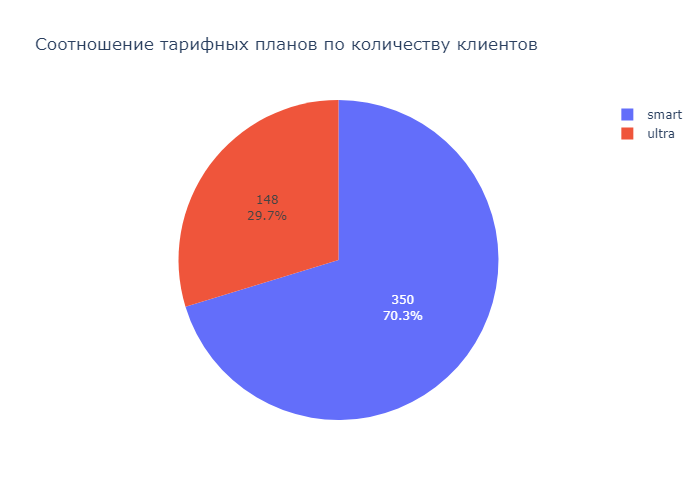

In [30]:
fig_1 = px.pie (data_main.groupby ('tariff')['user_id'].nunique().reset_index(),
                names = 'tariff',
                values = 'user_id',
                title = 'Соотношение тарифных планов по количеству клиентов')
fig_1.update_traces (textinfo = 'percent+value')
fig_1.show ('png')

Более 70% клиентов используют тариф "smart" - это стоит учитывать в общих выводах проекта. Рассмотрим динамику средних значений минут, сообщений и интернет-трафика по месяцам.

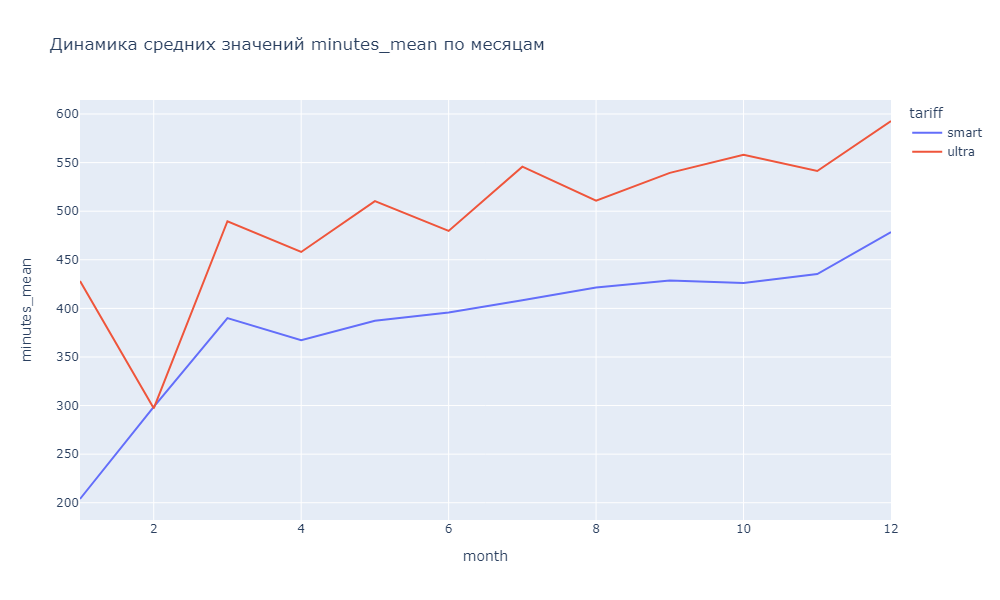

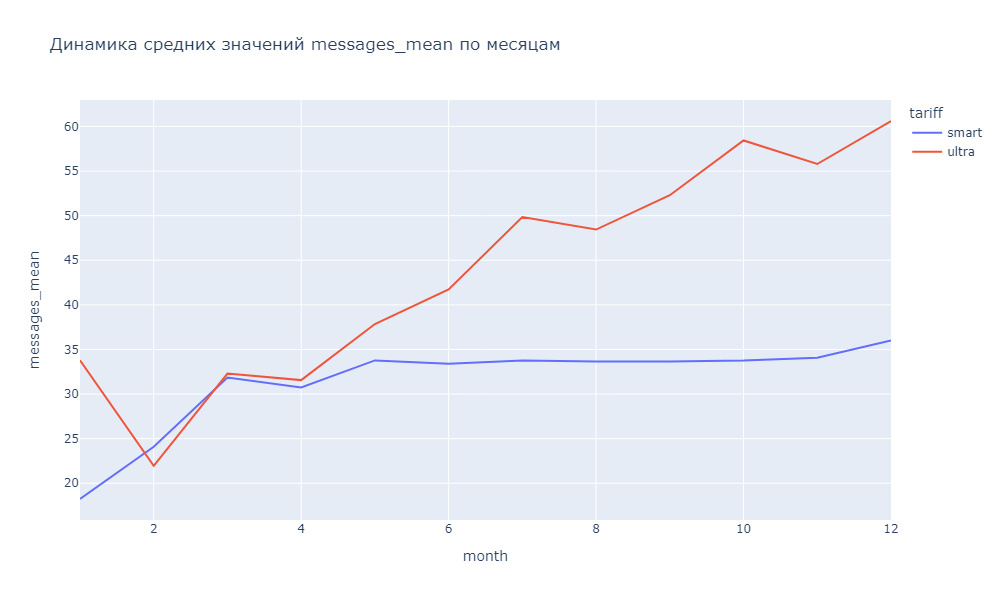

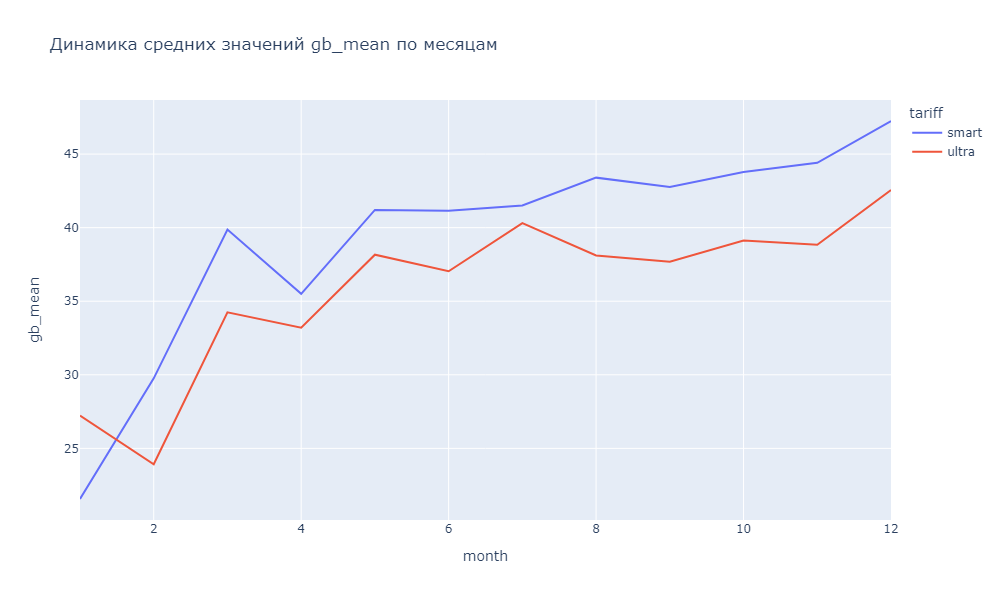

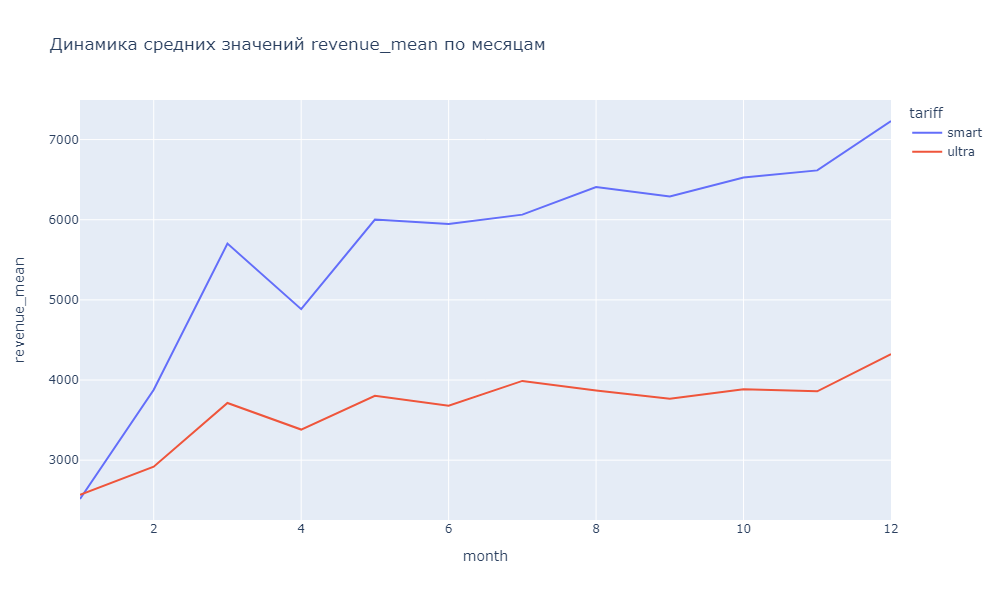

In [31]:
data_main_by_month = data_main.groupby (['tariff', 'month'],
                                        as_index = False).agg (minutes_mean = ('minutes_total', np.mean),
                                                               messages_mean = ('messages_count', np.mean),
                                                               gb_mean = ('gb_total', np.mean),
                                                               revenue_mean = ('revenue', np.mean))

for i in ['minutes_mean', 'messages_mean', 'gb_mean', 'revenue_mean']:
    fig = px.line (data_main_by_month,
                   x = 'month',
                   y = i,
                   color = 'tariff',
                   title = f'Динамика средних значений {i} по месяцам',
                   height = 600,
                   width = 1000)
    fig.show ('png')

По графикам видно, что в среднем пользователи тарифа "ultra" тратят больше минут, сообщений и интернет трафика. При этом с каждым месяцем пользователи обоих тарифов увеличивают показатели активности. Вероятнее всего, это связано с притоком новых клиентов, подключаемых к данным тарифам в течение года.

Следует также отметить "потолок" в количестве сообщений у пользователей тарифа "smart" - 35 сообщений максимум. Это значение не изменялось более полугода, при том что этот же параметр у пользвателей тарифа "ultra" значительно рос с каждым месяцем, увеличившись почти в два раза по отношению к тарифу "smart" к концу года.

Средние значения выручки за каждый месяц показывают значительную разницу между двумя тарифами. Выручка с тарифа `smart` динамично увеличивается и в среднем выше в 1.5 раза, чем выручка с тарифа `ultra`.

По каждому из параметров (количество сообщений, израсходованных минут и интернет-трафика) расчитаем среднее значение, дисперсию и стандартное отклонение, а также построим графики распределения.

In [32]:
data_main.groupby ('tariff').agg (minutes_mean = ('minutes_total', np.mean),
                                  minutes_var = ('minutes_total', np.var),
                                  minutes_std = ('minutes_total', np.std),
                                  messages_mean = ('messages_count', np.mean),
                                  messages_var = ('messages_count', np.var),
                                  messages_std = ('messages_count', np.std),
                                  gb_mean = ('gb_total', np.mean),
                                  gb_var = ('gb_total', np.var),
                                  gb_std = ('gb_total', np.std))

,minutes_mean,minutes_var,minutes_std,messages_mean,messages_var,messages_std,gb_mean,gb_var,gb_std
tariff,,,,,,,,,
smart,417.934948,36219.315784,190.313730,33.384029,796.812958,28.227876,42.418125,223.296368,14.943104
ultra,526.623350,100873.633397,317.606098,49.363452,2285.266143,47.804457,38.164467,382.775769,19.564656


По построенной таблице видна значительна разница в показателях между двумя тарифами. Среднее значение, дисперсия и стандартное отклонение по всем показателям выше у тарифа "ultra". Рассмотрим графики распределения.

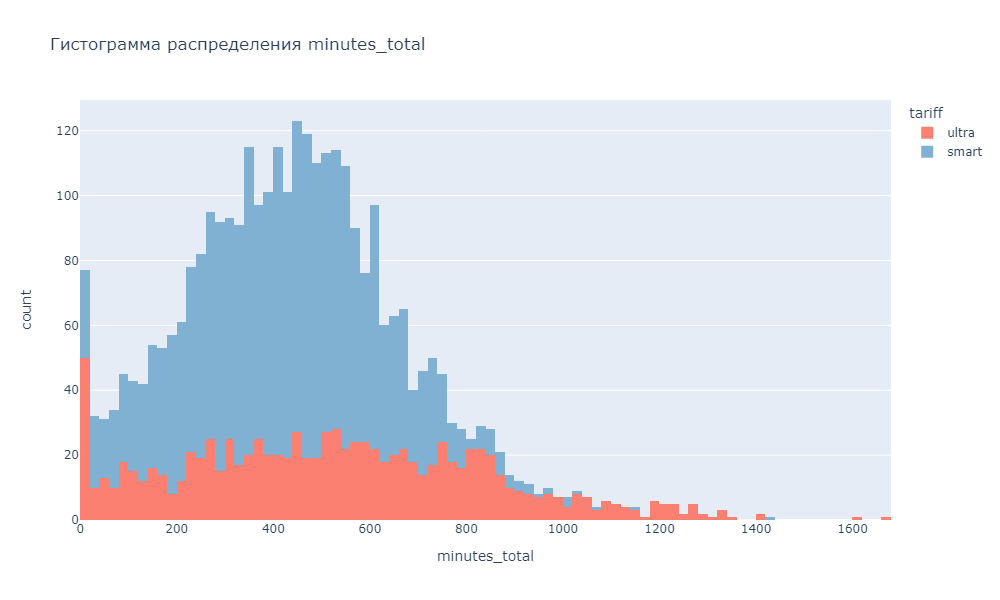

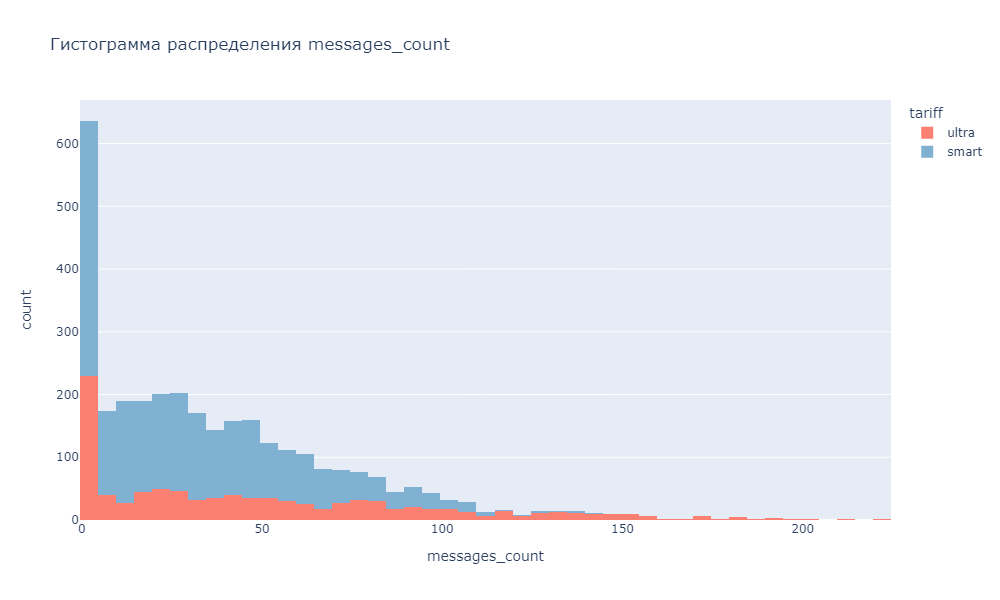

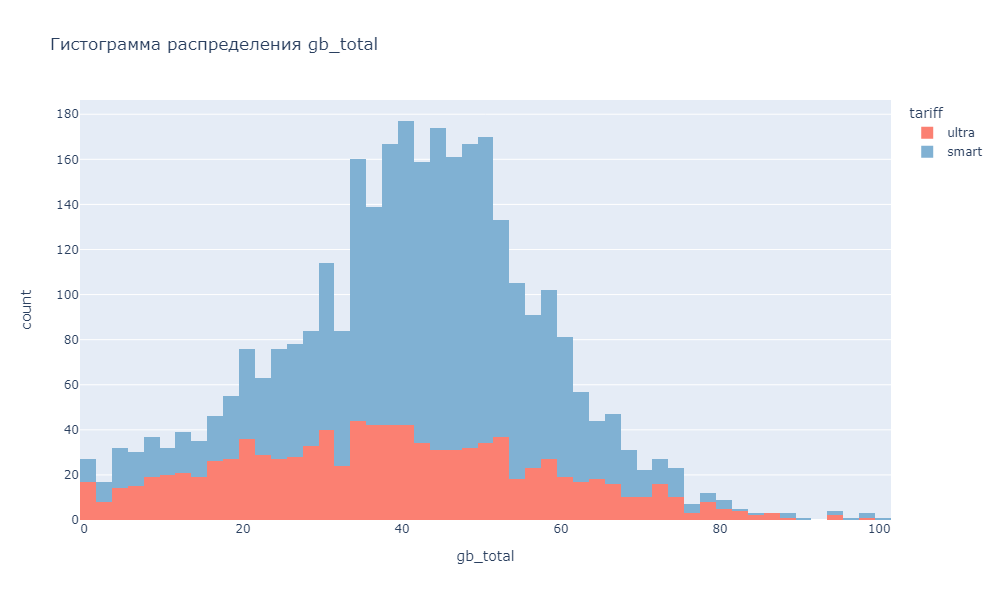

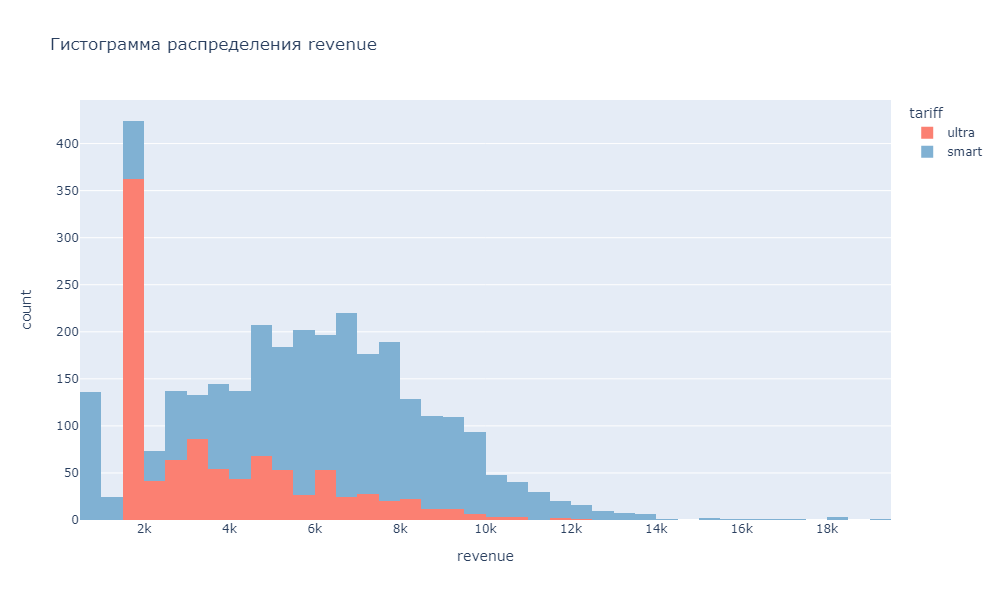

In [33]:
for i in ['minutes_total', 'messages_count', 'gb_total', 'revenue']:
    fig = px.histogram (data_main,
                        x = i,
                        color = 'tariff',
                        title = f'Гистограмма распределения {i}',
                        color_discrete_sequence = px.colors.qualitative.Set3[3:5],
                        height = 600,
                        width = 1000)
    fig.show ('png')

**Вывод:**

По графику распределения израсходованных минут видны ярковыраженные значения пользователей тарифа "smart" в диапазоне 300-500 минут. Значения пользователей тарифа "ultra" распределены более равномерно в более ширком диапазоне (200-800 минут), а также смещены правее, относительно пользователей тарифа "smart".

Гистограмма распределения отправленных сообщений отражает значительное количество клиентов, которые не пользуются этим сервисом. По этому показателю также наглядно видно количество клиентов обоих тарифов в соотношении 1:3. Оба тарифа имеют нисходящую тенденцию в зависимости от увеличения количества СМС.

График израсходованного интернет-трафика подобен графику со звонками. Имеется пик значений у пользователей тарифа "smart" в диапазоне от 30 до 50 Гб, в то время, как пользователи тарифа "ultra" более-менее равномерно распределены по значениям.

Гистограмма выручки наглядно показывает, что пользователи тарифа `smart` часто выходят за рамки минимальной ежемесячной оплаты, бывают случаи, что по тарифу `smart` клиенты платят даже больше, чем платили бы по тарифу `ultra`.

<a id="4"></a>
## Проверка гипотез
<a id="4.1"></a>
### Гипотеза №1
**Определим первую гипотезу:** Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

* H0  — средняя выручка пользователей тарифов "Ультра" и "Смарт" равны.
* H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

В данной гипотезе мы будем сравнивать две разные выборки, поэтому при проверке этой гипотезы воспользуемся методом `scipy.stats.ttest_ind`. Поскольку в условии гипотезы указано однозначное условие её подтверждения, установим допустимое пороговое значение `alpha = 1`. Для начала сравним размеры двух выборок и дисперсию значений по колонке `revenue`.

In [34]:
for i in data_main ['tariff'].unique():
    print (f'Размер выборки с тарифом {i}:', len (data_main.query ('tariff == @i')))
    print (f'Дисперсия выручки по тарифу {i}:', round (data_main.query ('tariff == @i')['revenue'].agg (np.var), 1))
    print()

Размер выборки с тарифом ultra: 985
Дисперсия выручки по тарифу ultra: 4692158.8

Размер выборки с тарифом smart: 2229
Дисперсия выручки по тарифу smart: 8373601.1



Сравниваемые выборки сильно отличаются как по размеру, так и по значению их дисперсии. Это следует учесть при использовании метода проверки (параметр `equal_var` установим со значением `False`).

In [35]:
result_1 = st.ttest_ind (data_main.query ('tariff == "smart"')['revenue'],
                         data_main.query ('tariff == "ultra"')['revenue'],
                         equal_var = False)
print ('p-value:', result_1.pvalue)
if result_1.pvalue < 0.01:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('НЕ отвергаем нулевую гипотезу')

p-value: 3.3661232169196476e-132
Отвергаем нулевую гипотезу


Проверим получившиеся результаты с помощью диаграмм размаха.

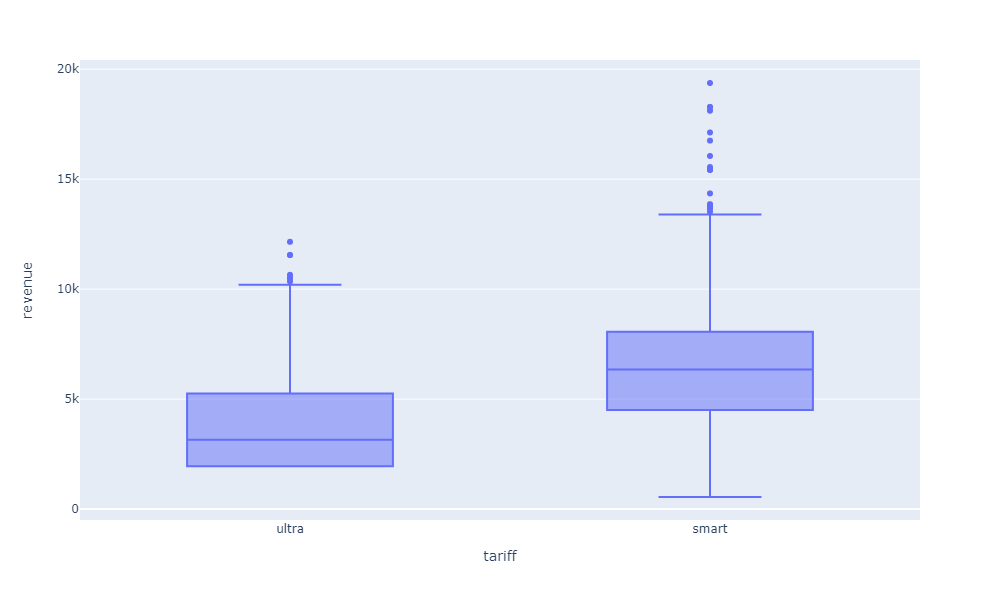

In [36]:
fig_2 = px.box (data_main, x = 'tariff', y = 'revenue', height = 600, width = 1000)
fig_2.show ('png')

**Вывод:** Значение `p-value` превысило заданный нами параметр `alpha`. Диаграмма размаха также показала значительную разницу в выручке двух категорий пользователей. Тариф `ultra` максимально сконцентрирован у показателя ежемесячной платы (1950 руб), имея незначительно количество выборосов данных, в товремя как тариф `smart` имеет довольно большой охват средних значений в диапазоне от 550 до 1700 руб, а также имеет большое количество выбросов за пределами 3500 руб. Нулевую гипотезу можно отвергнуть, приняв альтернативную гипотезу - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".

<a id="4.2"></a>
### Гипотеза №2
**Определим вторую гипотезу:** Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

* H0  — средняя выручка пользователей из Москвы и пользователей из регионов равна.
* H1  — средняя выручка пользователей из Москвы и пользователей из регионов различается.

В данной гипотезе мы также будем сравнивать две разные выборки, поэтому при проверке этой гипотезы воспользуемся методом из предыдущего подраздела. Допустимое пороговое значение также примем равным `alpha = 1`. Добавим информацию о городе проживания в главный датасет `data_main`.

In [37]:
data_main = data_main.merge (data_users [['user_id', 'city']], on = 'user_id', how = 'left')
data_main ['city'] = np.where (data_main ['city'] == 'Москва', 'из Москвы', 'из региона')
data_main.sample (10)

,user_id,month,calls_count,minutes_total,messages_count,gb_total,tariff,revenue,city
2433,1381,11,91,567,41,54.0,ultra,5550.0,из Москвы
2284,1361,11,38,245,35,49.0,ultra,4800.0,из региона
1341,1209,10,38,322,66,52.0,smart,7998.0,из региона
1385,1217,10,69,463,74,36.0,smart,4822.0,из региона
314,1050,10,3,50,2,1.0,ultra,1950.0,из региона
847,1134,3,61,461,57,50.0,smart,7571.0,из региона
2208,1350,8,4,35,2,3.0,ultra,1950.0,из региона
1372,1215,10,56,329,16,44.0,smart,6350.0,из региона
2612,1408,5,15,95,3,8.0,smart,550.0,из региона
2110,1332,7,58,497,35,54.0,smart,8350.0,из Москвы


Сравним размеры двух выборок и дисперсию значений по колонке `revenue`.

In [38]:
for i in data_main ['city'].unique():
    print (f'Размер выборки пользователей {i}:', len (data_main.query ('city == @i')))
    print (f'Дисперсия выручки пользователей {i}:', round (data_main.query ('city == @i')['revenue'].agg (np.var), 1))
    print()

Размер выборки пользователей из региона: 2603
Дисперсия выручки пользователей из региона: 8768407.4

Размер выборки пользователей из Москвы: 611
Дисперсия выручки пользователей из Москвы: 7199795.9



Сравниваемые выборки сильно отличаются как по размеру, так и по значению их дисперсии. Учтём это при использовании метода проверки.

In [39]:
result_2 = st.ttest_ind (data_main.query ('city == "из Москвы"')['revenue'],
                         data_main.query ('city != "из Москвы"')['revenue'],
                         equal_var = False)
print ('p-value:', result_2.pvalue)
if result_2.pvalue < 0.01:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('НЕ отвергаем нулевую гипотезу')

p-value: 0.25438147756433427
НЕ отвергаем нулевую гипотезу


Проверим получившиеся результаты с помощью диаграмм размаха.

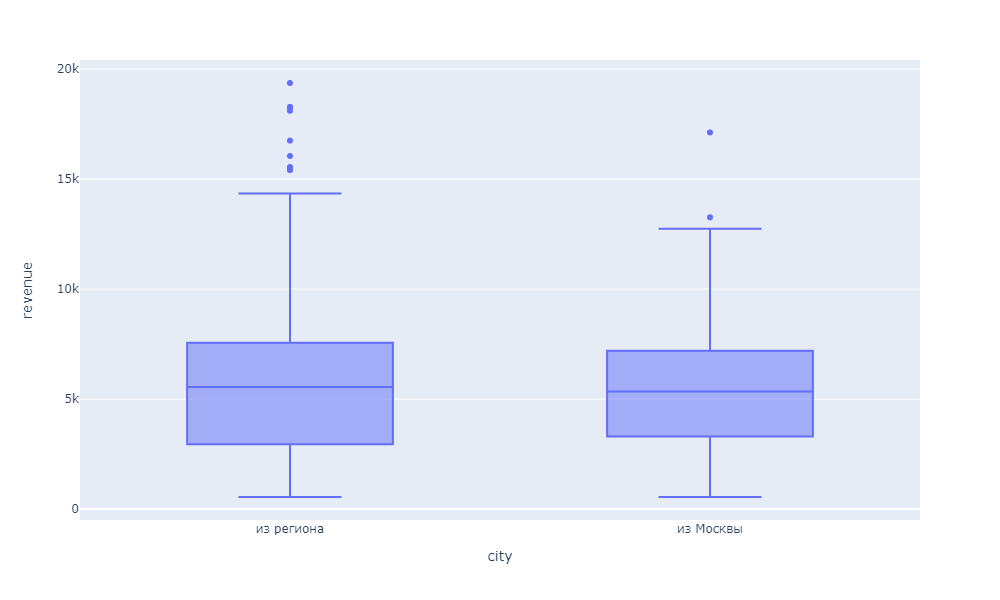

In [40]:
fig_3 = px.box (data_main, x = 'city', y = 'revenue', height = 600, width = 1000)
fig_3.show ('png')

**Вывод:** Значение `p-value` оказалось в пределах заданного нами параметра `alpha`. Диаграмма размаха также подтверждает примерно одинаковые средние значения у двух когорт. Единственная разница - значительное количество выбросов значений свыше 4000 руб у регионов, при более равномерном распределении у пользователей из Москвы. Нулевую гипотезу оставляем актуальной, альтернативную гипотезу отвергаем. Средняя выручка пользователей из Москвы и пользователей из регионов равна.

<a id="5"></a>
## Общие выводы

- Медианные значения выручки от тарифа `smart` - 965 руб, `ultra` - 1950 руб
- Пользователи тарифа `smart` значительно чаще превышают минимальный ежемесячный платёж, чем пользователи `ultra`
- Количество клиентов по обоим тарифным планам ежемесяно растёт - об этом говорит рост активности пользователей в течение года
- Наиболее популярным тарифным планом остаётся `smart` за счёт низкой стоимости
- Гипотеза №1 подтвердилась: средняя выручка в двух разных тарифов сильно отличается
- Гипотеза №2 не подтвердилась: город проживания пользователя практически не влияет на ежемесячные затраты

Тариф `smart`, имея более низкую ежемесячную оплату, приносит значительно больше прибыли, чем тариф `ultra`. Привлечение новых клиентов позволяет динамично увеличивать выручку.